In [1]:
# imports
import jax.numpy as jnp
from jax import jit, lax

import matplotlib.pyplot as plt
import numpy as np
from pyhgf.model import Network

import seaborn as sns

from typing import Tuple
import pandas as pd

When we have a mixture of different signals, sometimes using a single HGF may not precisely track or forecast the observations. Furthermore, there are some instances in which we are more interested in "filtering out" different components of a signal, and deal with them separately: we may want to use different HGFs that share some characteristic of the signal, but are able to work differently on different components. 
In this example we simulate some simple sinusoidal data made of different frequencies and analyzed with multiple concatenated HGFs. 

The type of concatenation we'll use consists in taking the prediction error from the node that tracks the input signal and using that as input data for another HGF.

# 0. Defining the function

In this example we will explore how to stack multiple HGF by their prediction error. Here you can find a function that computes this process automatically, but in the first part of the tutorial, for the sake of clarity, we will be doing the entire process manually

In [2]:
def concatenate_HGFs(
    HGFs: Tuple,
    node_idx: Tuple = None,
    input_type: Tuple = None,
    input_data = None,
    observed = None,
    ) -> Tuple:
    """A function that concatenates multiple HGFs.
    Specifically, it takes the prediction error or the residual from a chosen node 
    in the first specified HGF, and uses it as an input for the next specified HGF.

    Attributes
    ----------
    HGFs :
        A tuple containing the HGF to concatenate. They must be specified in the 
        exact order they will be concatenated.
    node_idx :
        A tuple containing the indexes of the node from which the prediction error 
        or the residual will be taken. The position of the node_idx in the tuple
        must match the one in the HGFs tuple. If not specified, it returns a tuple
        of the length of the HGFs tuple with all the node indexes set to 1.
    input_type :
        A tuple containing strings specifying the type of concatenation between the
        current specified HGF and the next one. It accepts `"prediction_error"` 
        or `""residual"` as inputs. If not specified, it returns a tuple
        of the length of the HGFs tuple filled with `"prediction_error"`.
    input_data :
        The array containing data to feed to the concatenated_HGF
    
    """
    # initialize variable if not specified
    if node_idx is None:
        node_idx = (1,)*len(HGFs)
    else:
        if len(node_idx) != len(HGFs):
            raise ValueError("The length of node_idx and the number of HGFs provided must be the same")
    if input_type is None:
        input_type = ("prediction_error",)*len(HGFs)

    # for each HGF retrieve the prediction error or residual

    fed_HGFs = ()

    for HGF_idx in range(len(HGFs)):

        #input data in the first HGF
        if HGF_idx == 0:
            new_HGF = HGFs[HGF_idx].input_data(input_data, observed=observed)
            fed_HGFs =  fed_HGFs + (new_HGF,)

            #calculate the residual or the prediction error 
            if input_type[HGF_idx] == "prediction_error":
                new_input = new_HGF.node_trajectories[node_idx[HGF_idx]]["mean"] - new_HGF.node_trajectories[node_idx[HGF_idx]]["expected_mean"]
                # posterior mean - expected mean
            elif input_type[HGF_idx] == "residual":
                new_input = input_data - new_HGF.node_trajectories[node_idx[HGF_idx]]["mean"]
                # posterior mean of the child - posterior mean of the node
            else:
                raise ValueError("Argument not valid")
        
        else:

            new_HGF = HGFs[HGF_idx].input_data(new_input, observed=observed)
            fed_HGFs =  fed_HGFs + (new_HGF,)

            if input_type[HGF_idx] == "prediction_error":
                new_input = new_HGF.node_trajectories[node_idx[HGF_idx]]["mean"] - new_HGF.node_trajectories[node_idx[HGF_idx]]["expected_mean"]
                # posterior mean - expected mean
            elif input_type[HGF_idx] == "residual":
                new_input = new_input - new_HGF.node_trajectories[node_idx[HGF_idx]]["mean"]
                # posterior mean of the child - posterior mean of the node
            else:
                raise ValueError("Argument not valid")
            
            # feeding the HGFs with the data and creating a Tuple of corresponding fed HGFs

    

    return fed_HGFs
        
        


# 1. Simulating data and manually concatenating the HGFs

## 1.1 Input data
Let's simulate a signal composed by two sinusoids with different frequencies. We may want to be able to track the different frequencies with different HGFs: in order to do so, one way will be inputing the data to a first HGF designed to filter the lower frequencies, taking the prediction error from the node that it's traking the signal's behaviour (that should be encoding the "filtered out" signal), and feeding a new HGF with that prediction error.

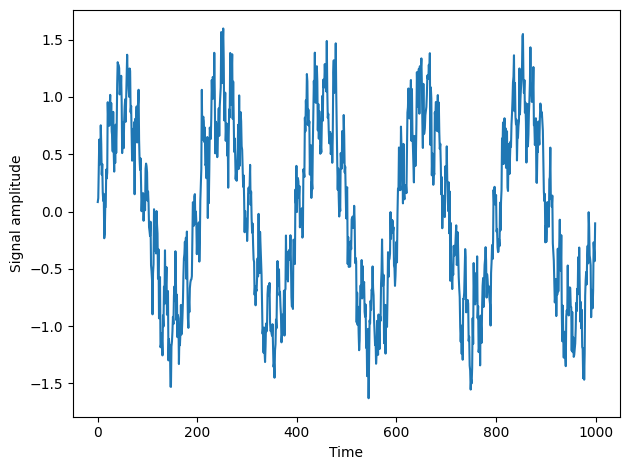

In [3]:
np.random.seed(42)
x = np.arange(0,1000)
std = 0.01
omega_1 = 1/3
omega_2 = 1/32


input_data = np.sin(x*omega_1)/3 + np.sin(x*omega_2) + np.random.normal(0,0.5,1000)/3
oscillation_number_omega_1 = len(x)*omega_1/(2*np.pi)
oscillation_number_omega_2 = len(x)*omega_2/(2*np.pi)


plt.plot(x, input_data)
plt.xlabel("Time")
plt.ylabel("Signal amplitude")
plt.tight_layout()
plt.show()


## 1.2 Creating the linear HGFs
Now we create the HGFs - they are all linear and have 2-levels, $x_1$ and $x_2$. $\lambda_1$ will be set to 0. The tonic volatility of $x_1$ of HGF1 will be set very low, to capture the low frequency component, while the input precision will be increased in each subsequent HGF.

HGF1 will receive data as input, HGF2 will receive the prediction error for $x_1$ of HGF1, and HGF3 will receive the prediction error for $x_1$ of HGF2.

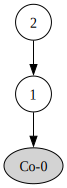

In [4]:
hgf1 = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=100.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0,
               precision = 1.0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,
               tonic_volatility=-6,) # x2 - node 2, value parent
)

hgf2 = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=100.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,) # x2 - node 2, value parent
)

hgf3 = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=100.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,) # x2 - node 2, value parent
)

hgf4 = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=100.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,) # x2 - node 2, value parent
)

hgf1.plot_network()

## 1.3 Feeding the HGFs
### 1.3.1 HGF1 feeding 

We now input the input data into the first HGF. Notice how the expected mean tracks the low frequency component.

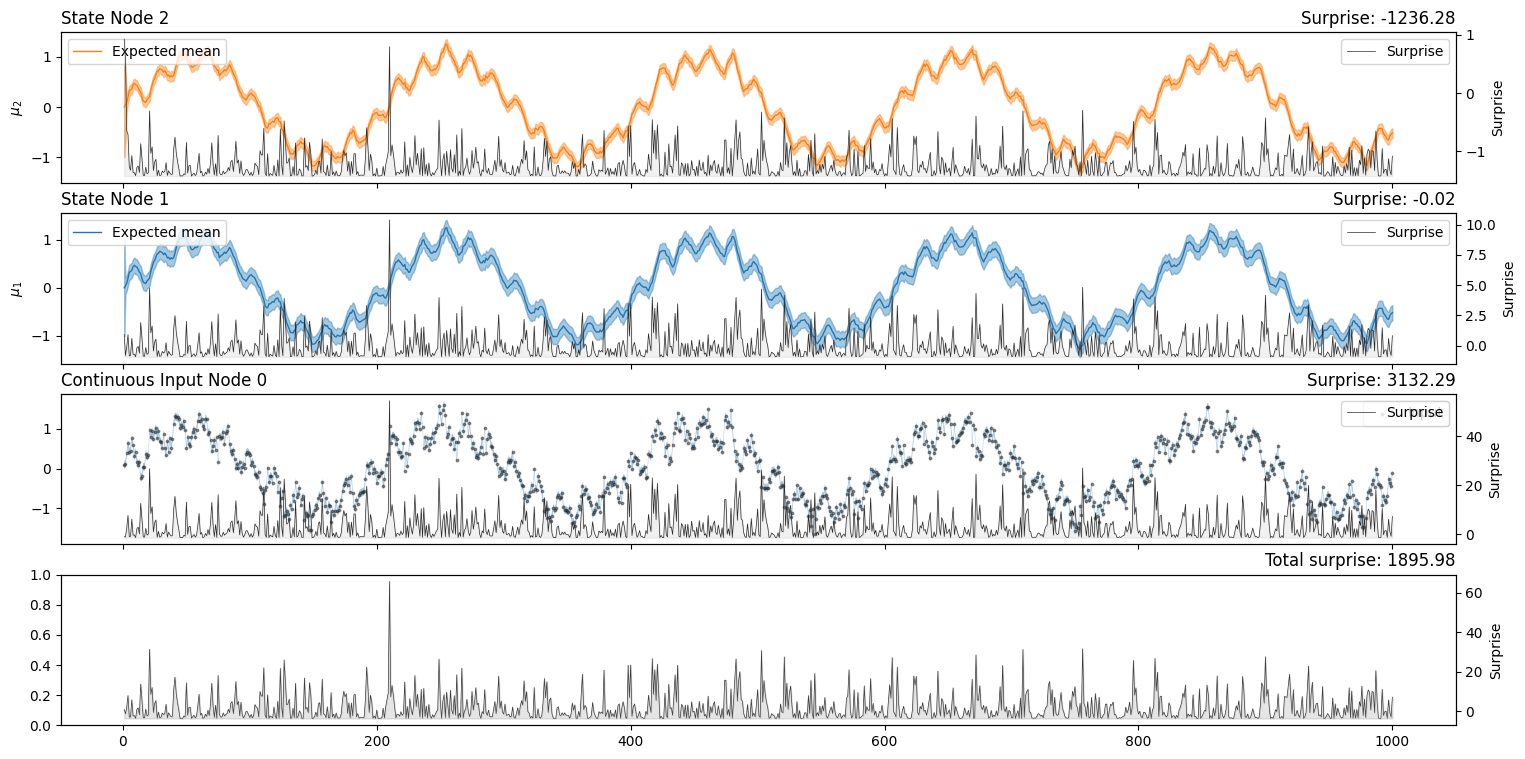

In [5]:
hgf1 = hgf1.input_data(input_data)
hgf1.plot_trajectories();

We then calculate the prediction error. Notice how it oscillates with the same frequency as the high frequency oscillation of the input data.

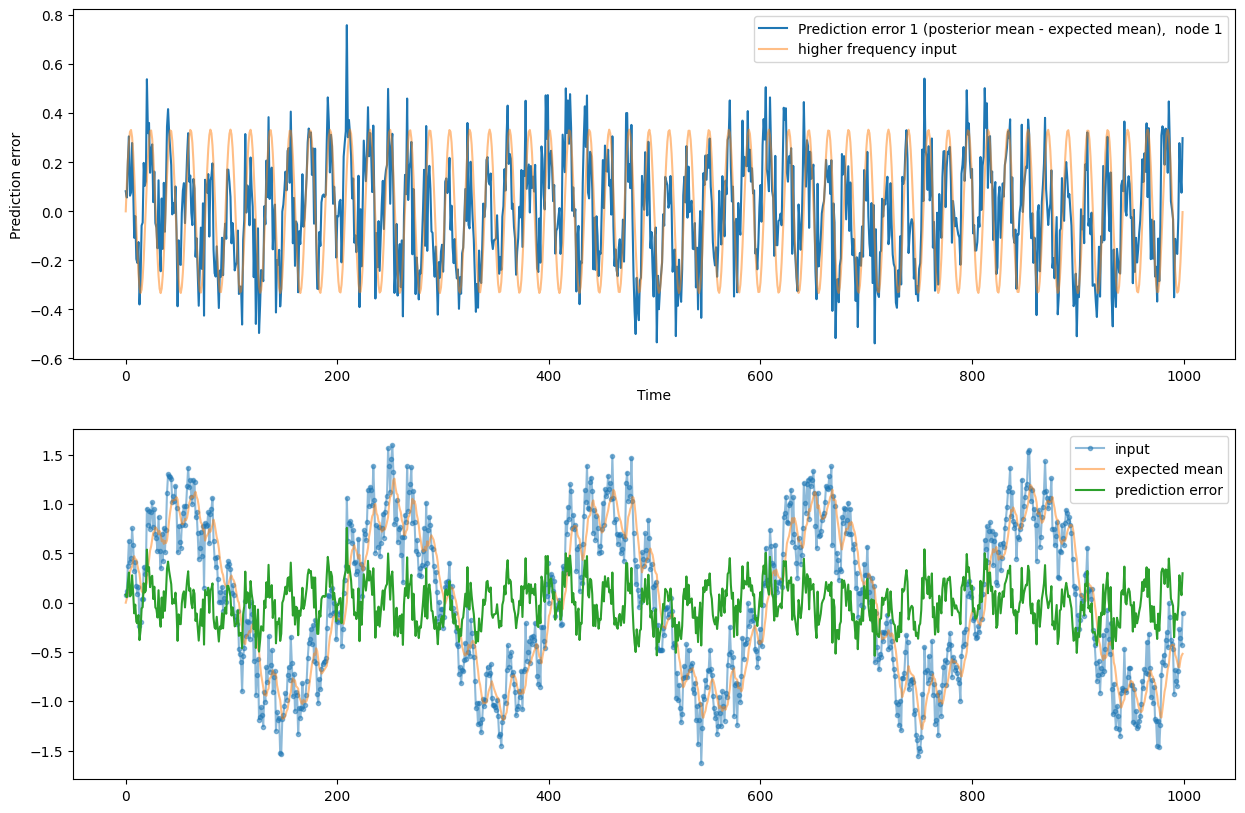

In [6]:
# calculating the prediction errors of node 1

fig, axs = plt.subplots(2,1, figsize=(15,10))
pe1 = -hgf1.node_trajectories[1]["expected_mean"] + hgf1. node_trajectories[1]["mean"]
axs[0].plot(pe1, label="Prediction error 1 (posterior mean - expected mean),  node 1")
axs[0].plot(np.sin(x*omega_1)/(3), label="higher frequency input", alpha=0.5) #plotting lorenz attractor too :)
axs[0].legend()
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Prediction error")

axs[1].plot(input_data, label="input", alpha=0.5, marker=".")
axs[1].plot(hgf1.node_trajectories[1]["expected_mean"], label="expected mean", alpha=0.5)
axs[1].plot(pe1, label="prediction error")
axs[1].legend()


### 1.3.2 Feeding HGF2, HGF3 and HGF4
Now we feed the second HGF using the prediction error of $x_1$ from the previous HGF.

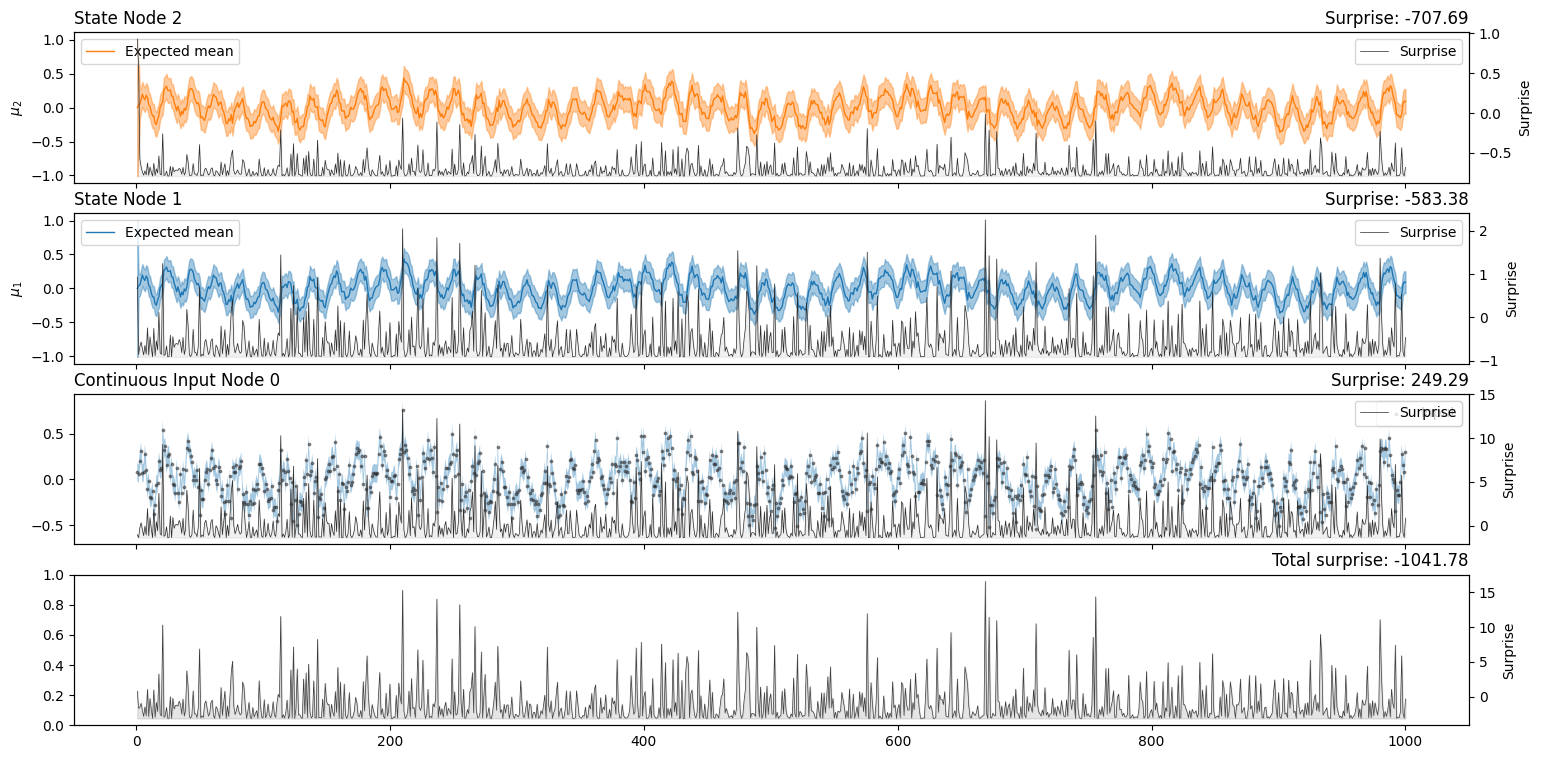

In [7]:
hgf2 = hgf2.input_data(pe1)
hgf2.plot_trajectories();

We calculate the PE for the second HGF and use it as input for the third HGF. 

array([<Axes: title={'left': 'State Node 2'}, ylabel='$\\mu_{2}$'>,
       <Axes: title={'left': 'State Node 1'}, ylabel='$\\mu_{1}$'>,
       <Axes: title={'left': 'Continuous Input Node 0'}>, <Axes: >],
      dtype=object)

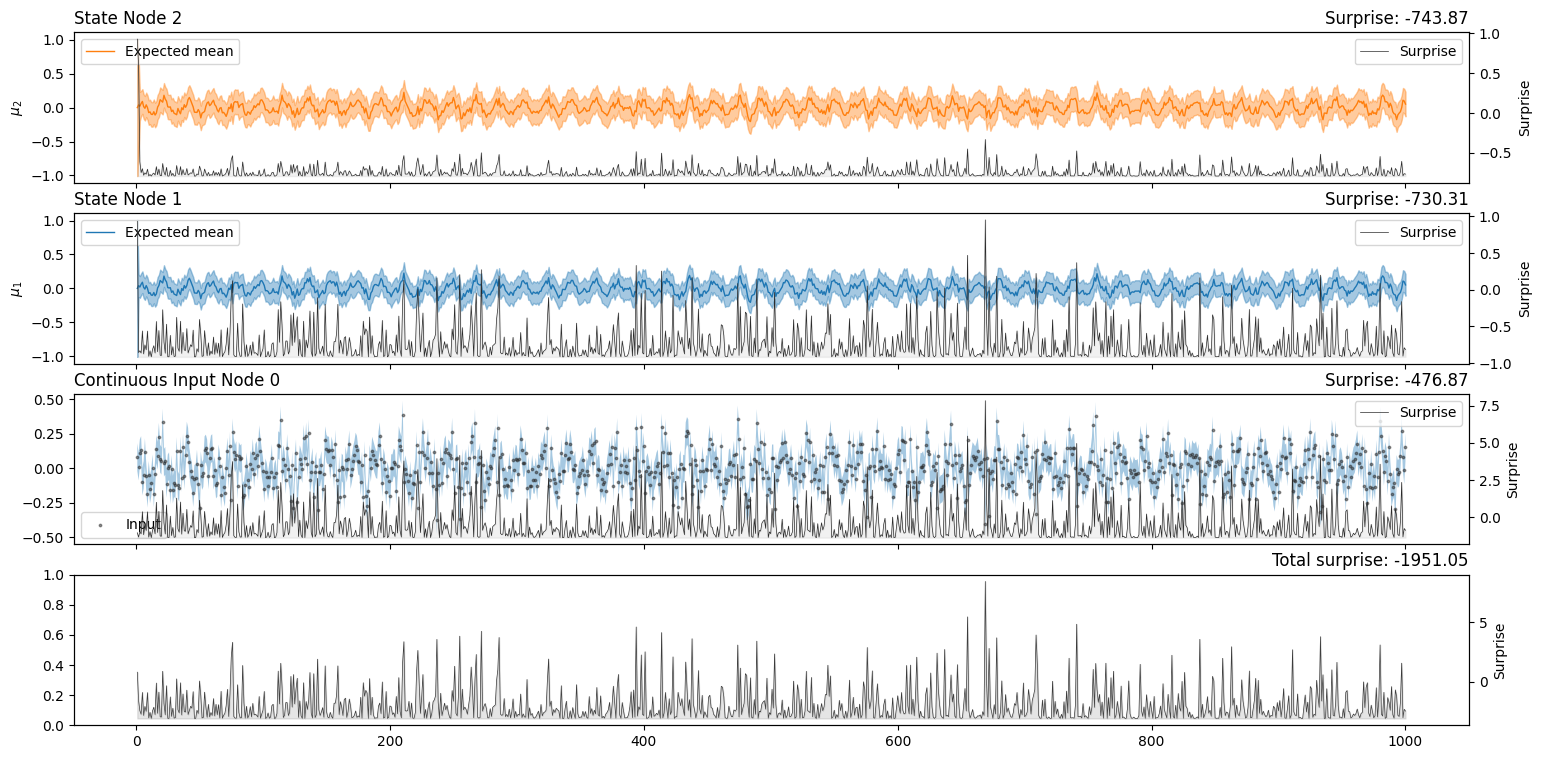

In [8]:
pe2 = -hgf2.node_trajectories[1]["expected_mean"] + hgf2. node_trajectories[1]["mean"]
hgf3 = hgf3.input_data(pe2)
hgf3.plot_trajectories()

We repeat the same steps concatenating HGF3 and HGF4.

array([<Axes: title={'left': 'State Node 2'}, ylabel='$\\mu_{2}$'>,
       <Axes: title={'left': 'State Node 1'}, ylabel='$\\mu_{1}$'>,
       <Axes: title={'left': 'Continuous Input Node 0'}>, <Axes: >],
      dtype=object)

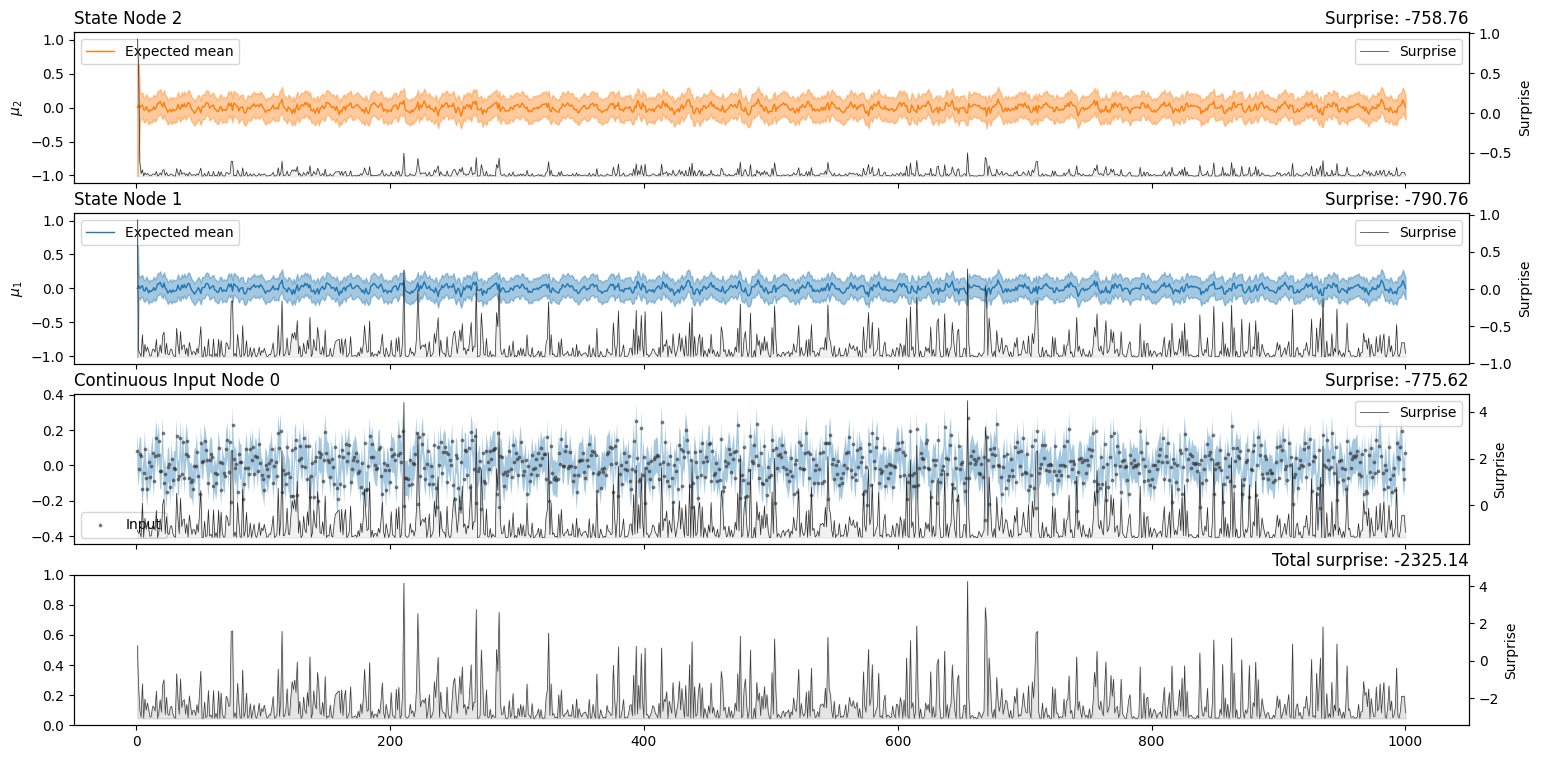

In [9]:
pe3 = -hgf3.node_trajectories[1]["expected_mean"] + hgf3. node_trajectories[1]["mean"]
hgf4 = hgf4.input_data(pe3)
hgf4.plot_trajectories()

Notice how we are progressively filtering out the low-frequency oscillation component, and reducing the amplitude os our signal at each step. We may want to add more HGFs during real-life application, until we reach a signal that is indistinguishable from random noise.

## 2. Creating a linear multilevel HGF for comparison
For the sake of comparison, we now create a 3-level HGF fed with the same input data as HGF1.

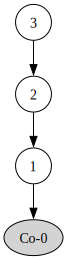

In [10]:
big_HGF = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=100.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,
               autoconnection_strength=1) # x2 - node 2, value parent
    .add_nodes(value_children=2, 
               n_nodes=1,
               autoconnection_strength=1) # x3 - node 3, value parent
)

big_HGF.plot_network()

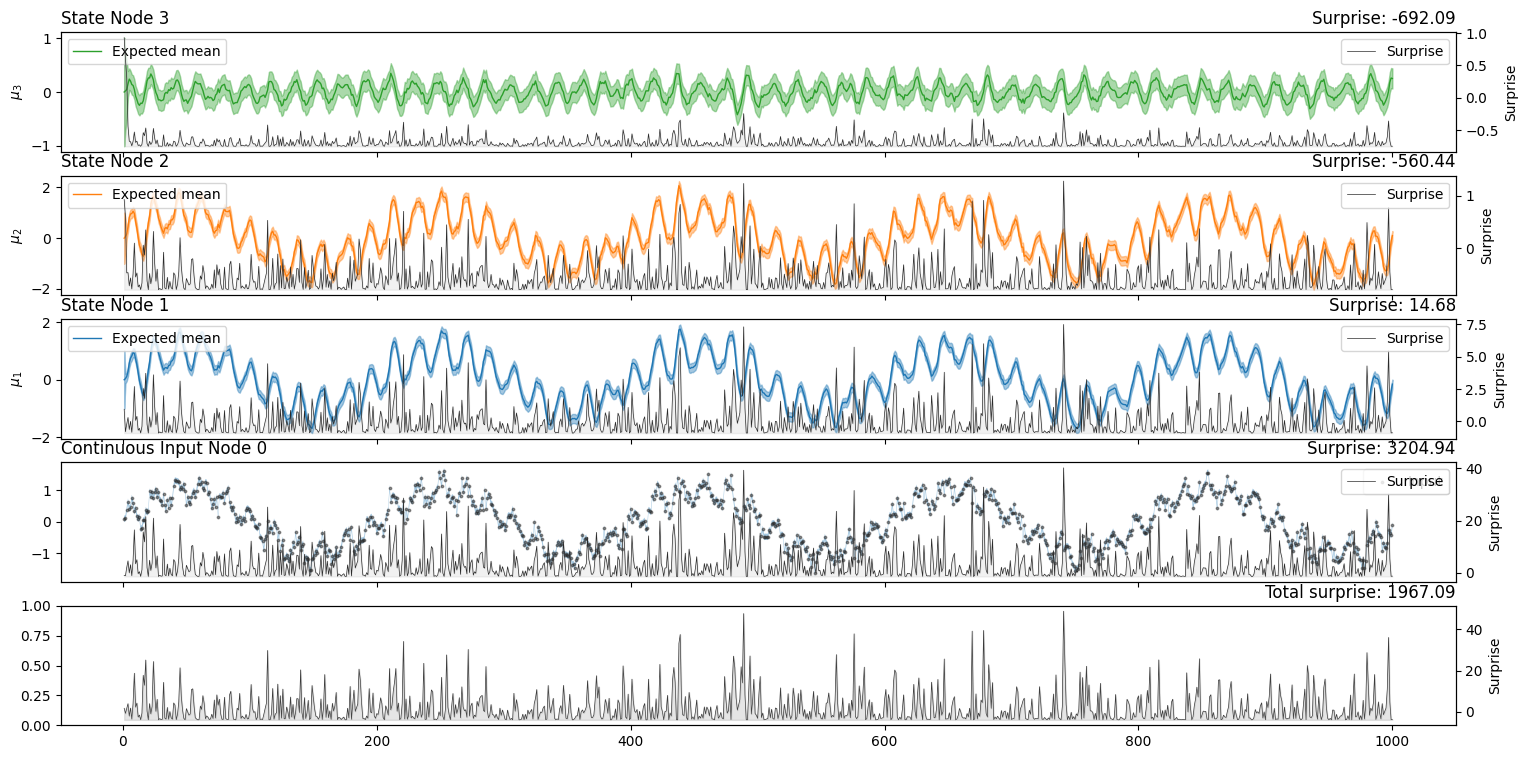

In [11]:
big_HGF = big_HGF.input_data(input_data)
big_HGF.plot_trajectories();

Let's compare the single HGFs prediction means with the one expected by the multilevel HGF per se.

Text(0.5, 1.0, '3 levels HGF')

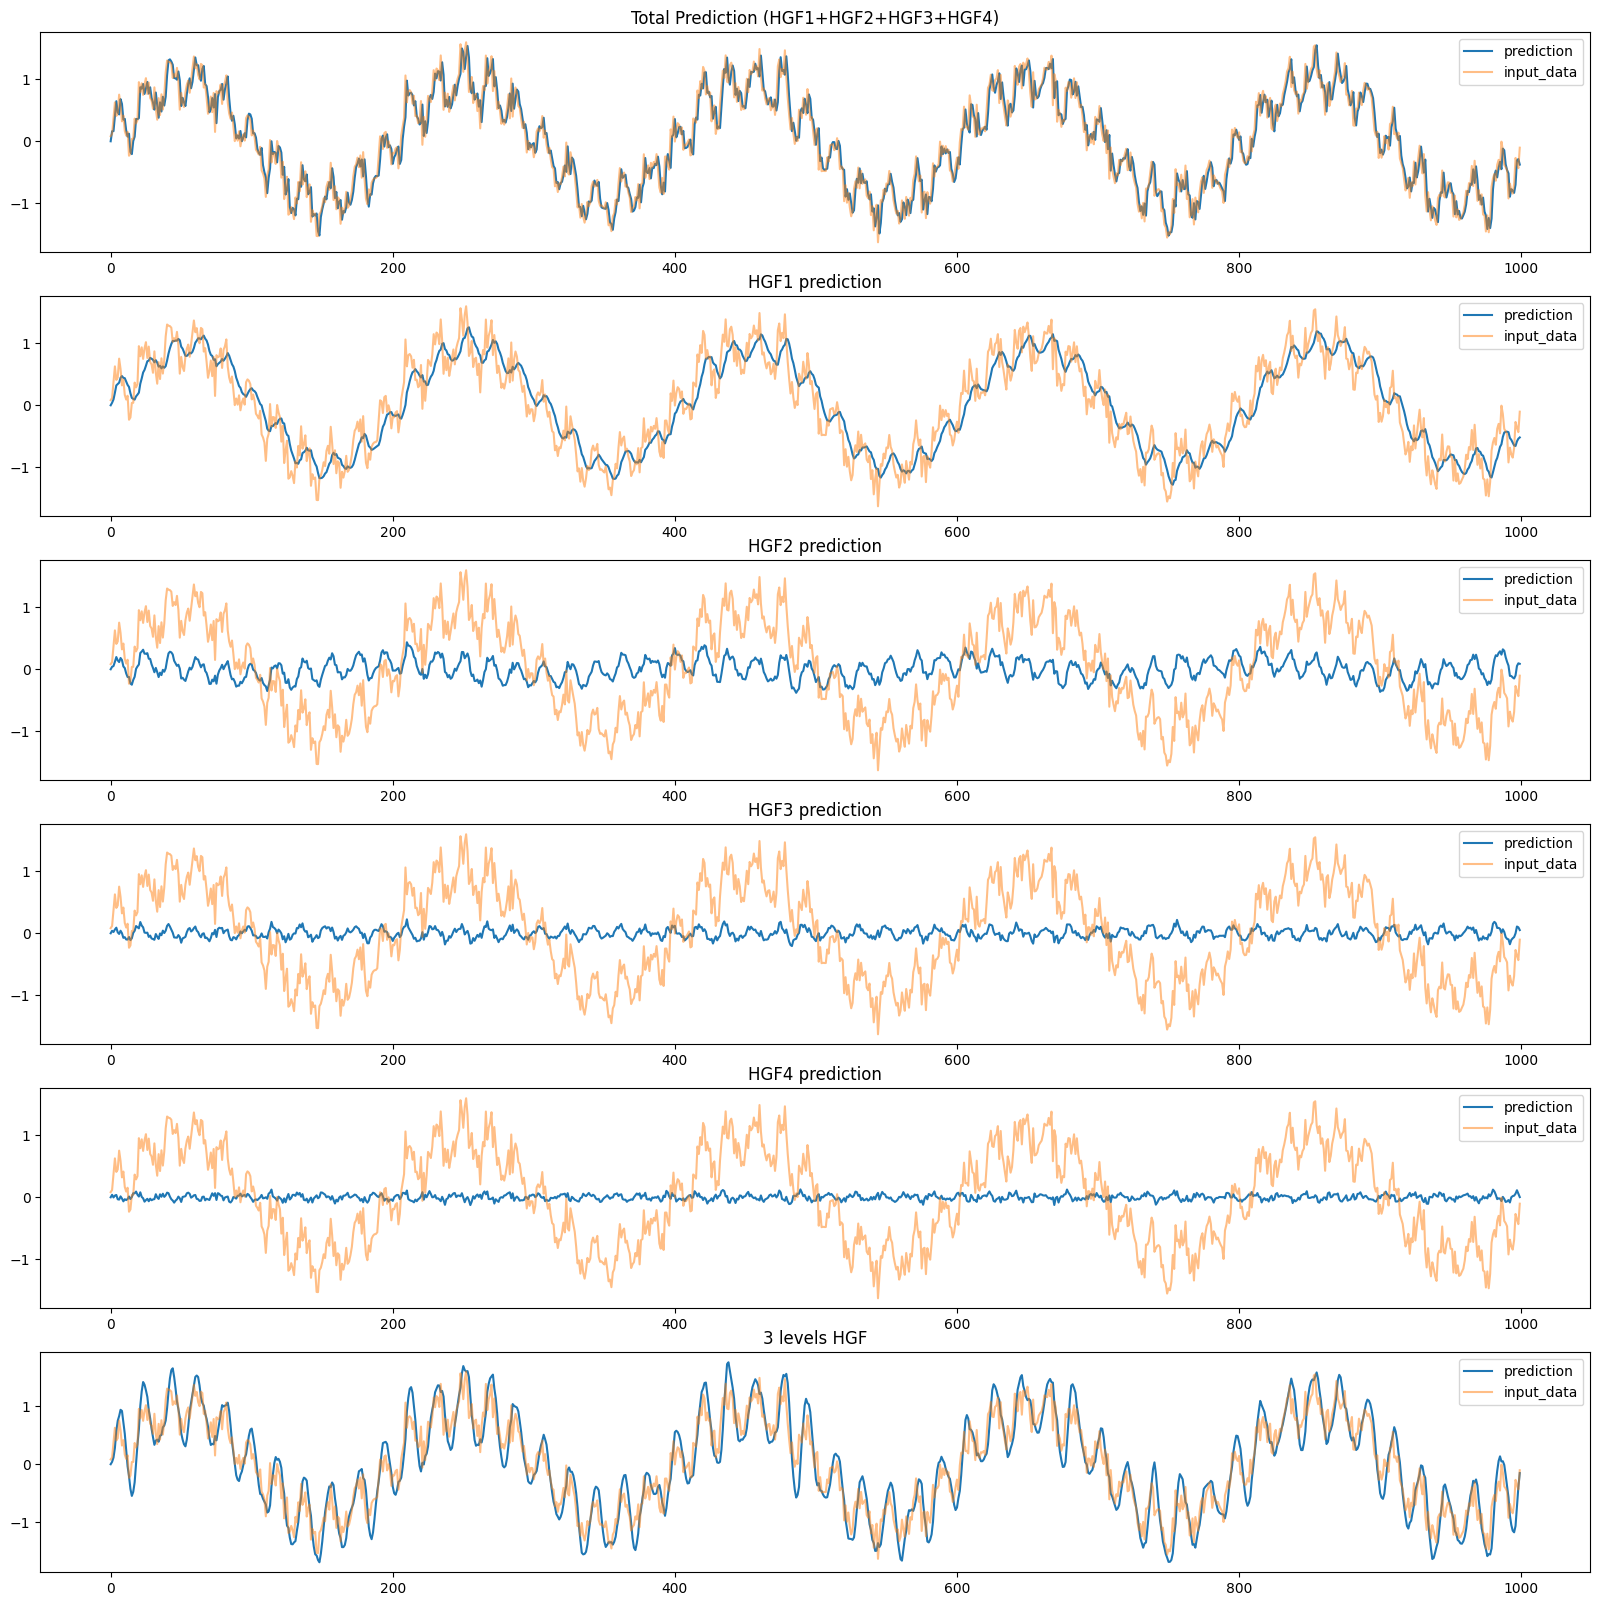

In [12]:
hgf1_prediction = hgf1.node_trajectories[1]["expected_mean"]
hgf2_prediction = hgf2.node_trajectories[1]["expected_mean"]
hgf3_prediction = hgf3.node_trajectories[1]["expected_mean"]
hgf4_prediction = hgf4.node_trajectories[1]["expected_mean"]
pehgf_total_prediction = hgf1_prediction + hgf2_prediction + hgf3_prediction + hgf4_prediction

fig, ax = plt.subplots(6,1, figsize=(20,20))

ax[0].plot(pehgf_total_prediction, label="prediction")
ax[0].plot(input_data, alpha=0.5, label="input_data")
ax[0].legend()
ax[0].set_title("Total Prediction (HGF1+HGF2+HGF3+HGF4)")

ax[1].plot(hgf1_prediction, label="prediction")
ax[1].plot(input_data, alpha=0.5, label="input_data")
ax[1].legend()
ax[1].set_title("HGF1 prediction")

ax[2].plot(hgf2_prediction, label="prediction")
ax[2].plot(input_data, alpha=0.5, label="input_data")
ax[2].legend()
ax[2].set_title("HGF2 prediction")

ax[3].plot(hgf3_prediction, label="prediction")
ax[3].plot(input_data, alpha=0.5, label="input_data")
ax[3].legend()
ax[3].set_title("HGF3 prediction")

ax[4].plot(hgf4_prediction, label="prediction")
ax[4].plot(input_data, alpha=0.5, label="input_data")
ax[4].legend()
ax[4].set_title("HGF4 prediction")

ax[5].plot(big_HGF.node_trajectories[1]["expected_mean"], label="prediction")
ax[5].plot(input_data, alpha=0.5, label="input_data")
ax[5].legend()
ax[5].set_title("3 levels HGF")




You can notice how the sum of the predicted means of all the HGFs fits the data better than the 3-level HGF (feel free to try with 2 or 4 levels too).

## 3. Repeat with an automatic function

When we want to concatenate HGFs, we can either do that manually, as we showed in this tutorial, or use the concatenate_HGF function. 
You can input the HGFs as an ordered tuple, specifying the nodes that have to provide the prediction error as an input for the next HGF. The argument input_type allow to specify whether we want to use the prediction error or the residual as the new input for the next node.

In [13]:
hgfa = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=100.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,
               tonic_volatility=-6,) # x2 - node 2, value parent
)

hgfb = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=100.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,) # x2 - node 2, value parent
)

hgfc = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=100.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,) # x2 - node 2, value parent
)

hgfd = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=100.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,) # x2 - node 2, value parent
)

Now we use the concatenate_HGFs function to retrieve the concatenated networks

In [14]:
(hgfa,hgfb,hgfc,hgfd) = concatenate_HGFs(HGFs =(hgfa,hgfb,hgfc,hgfd), 
                                         input_data = input_data,
                                         #node_idx=(1,1,1,1,), 
                                         #input_type = ("residual", "residual", "residual", "residual")
)

Text(0.5, 1.0, '3 levels HGF')

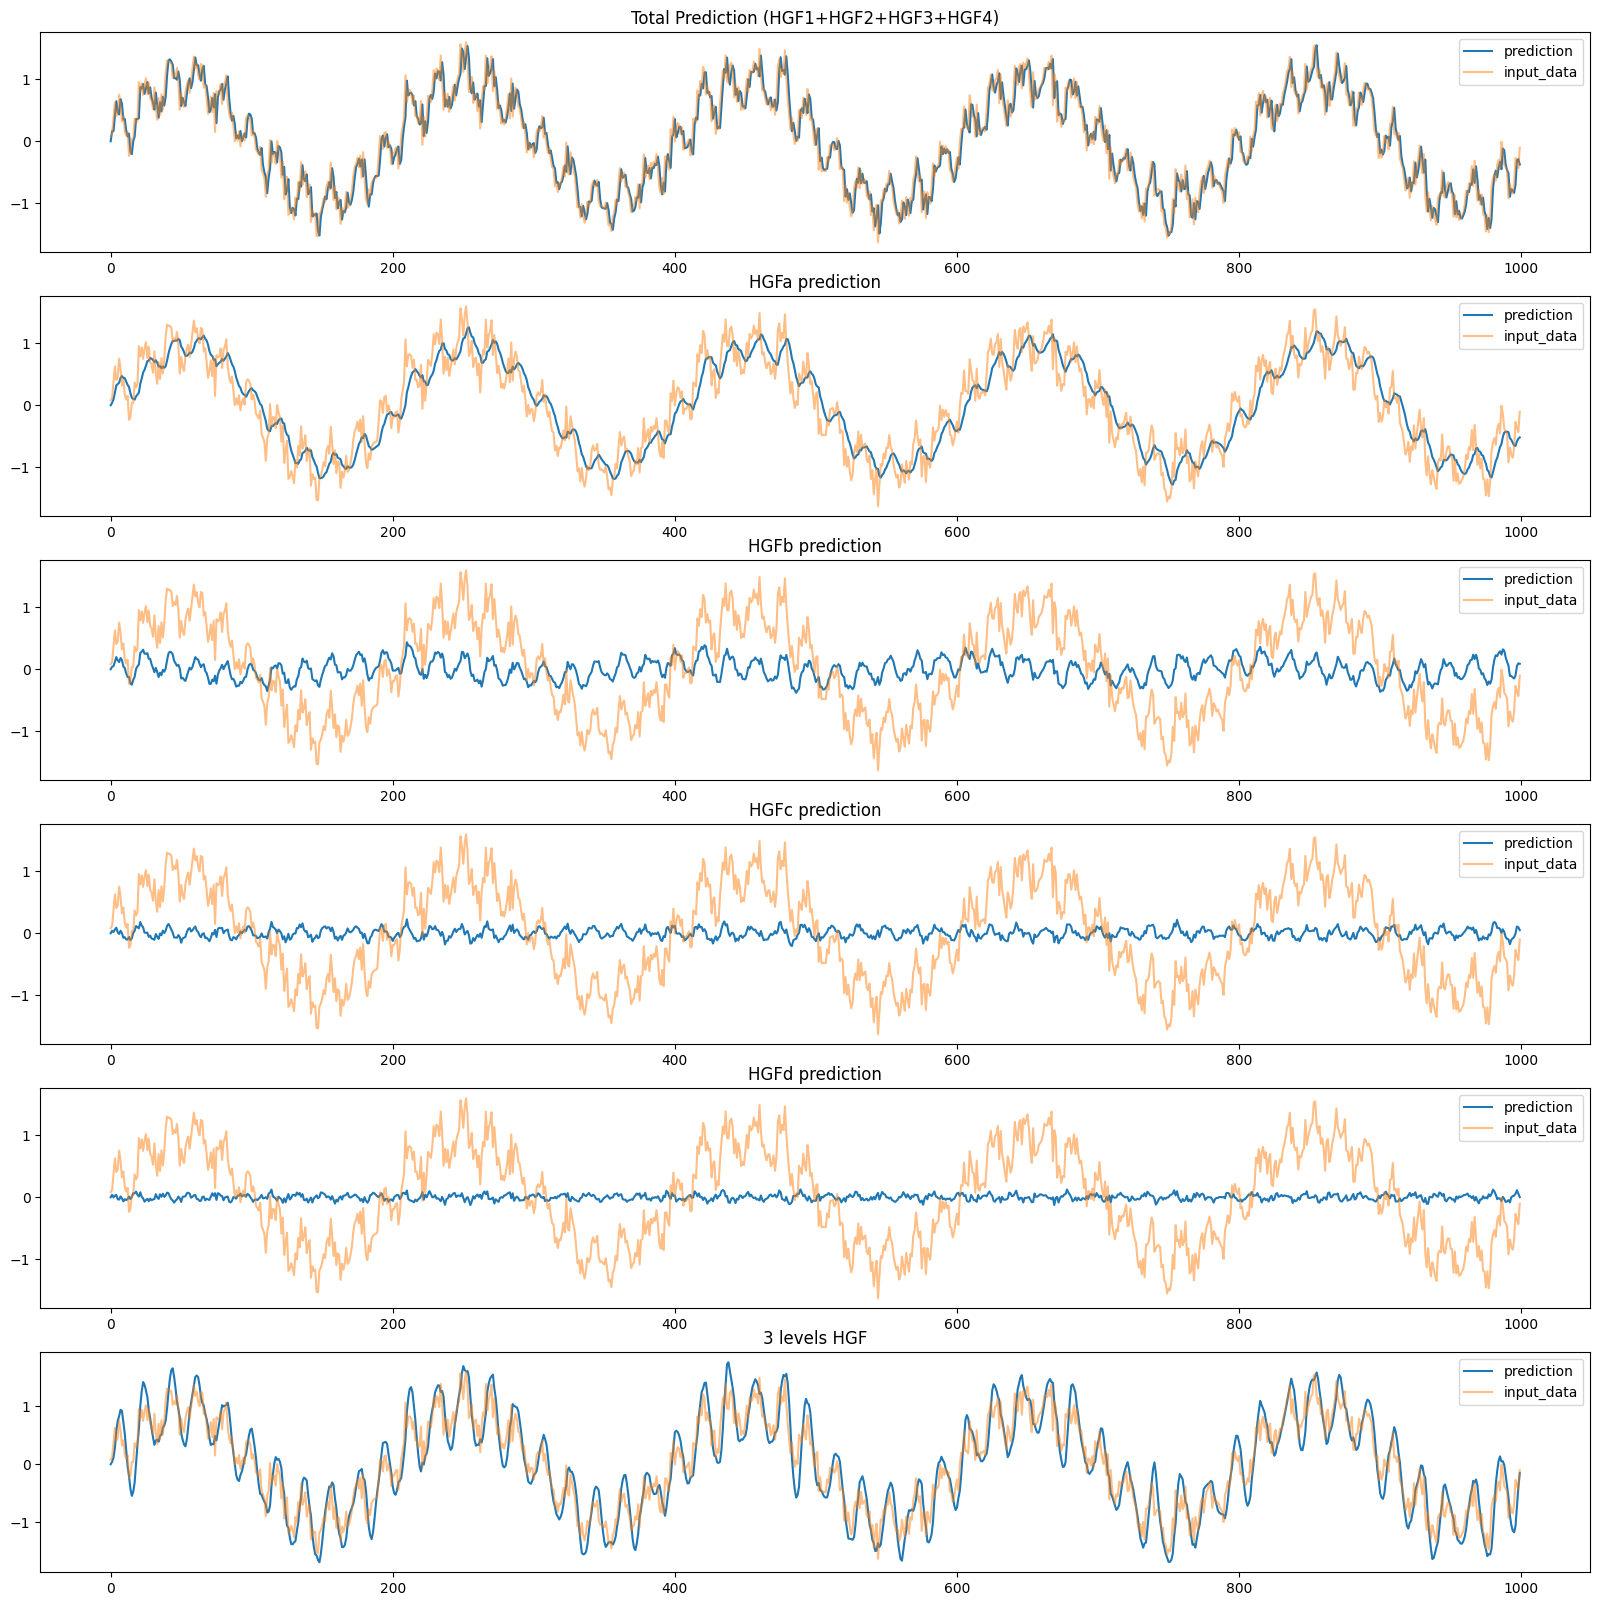

In [15]:
hgfa_prediction = hgfa.node_trajectories[1]["expected_mean"]
hgfb_prediction = hgfb.node_trajectories[1]["expected_mean"]
hgfc_prediction = hgfc.node_trajectories[1]["expected_mean"]
hgfd_prediction = hgfd.node_trajectories[1]["expected_mean"]
pehgf_total_prediction = hgfa_prediction + hgfb_prediction + hgfc_prediction + hgfd_prediction

fig, ax = plt.subplots(6,1, figsize=(20,20))

ax[0].plot(pehgf_total_prediction, label="prediction")
ax[0].plot(input_data, alpha=0.5, label="input_data")
ax[0].legend()
ax[0].set_title("Total Prediction (HGF1+HGF2+HGF3+HGF4)")

ax[1].plot(hgfa_prediction, label="prediction")
ax[1].plot(input_data, alpha=0.5, label="input_data")
ax[1].legend()
ax[1].set_title("HGFa prediction")

ax[2].plot(hgfb_prediction, label="prediction")
ax[2].plot(input_data, alpha=0.5, label="input_data")
ax[2].legend()
ax[2].set_title("HGFb prediction")

ax[3].plot(hgfc_prediction, label="prediction")
ax[3].plot(input_data, alpha=0.5, label="input_data")
ax[3].legend()
ax[3].set_title("HGFc prediction")

ax[4].plot(hgfd_prediction, label="prediction")
ax[4].plot(input_data, alpha=0.5, label="input_data")
ax[4].legend()
ax[4].set_title("HGFd prediction")

ax[5].plot(big_HGF.node_trajectories[1]["expected_mean"], label="prediction")
ax[5].plot(input_data, alpha=0.5, label="input_data")
ax[5].legend()
ax[5].set_title("3 levels HGF")

# 4. Use the concatenated HGFs combination with non-linear function for forecasting

It is possible to use the concatenated HGFs to make predictions, if you know some of the underlying functions you want to filter out of the signal at each level. 
In the previous example, we can use the non-linear value coupling to design 2 HGFs that filter sinusoidal oscillations at different frequencies.

In [16]:
# create chunck of missing values
observed = np.ones(1000)
observed[250:350] = 0
observed[550:650] = 0
observed[850:950] = 0

The first 2 HGFs consist in 2-levels HGF with non linear sinusoidal value coupling between $x_1$ and $x_2$. We assume a constant tonic drift in the "clock parent" $x_2$: this ensure a fixed sinusoidal frequency.

In [17]:
hgfa = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=10.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,
               coupling_fn = (jnp.sin,),
               tonic_drift = omega_2,
               ) # x2 - node 2, clock parent


)

hgfb = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=10.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,
               coupling_fn = (jnp.sin,),
               tonic_drift = omega_1,
               ) # x2 - node 2, clock parent


)

hgfc = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=10.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,)
)


hgfd = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=100.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,) # x2 - node 2, value parent
)


big_HGF = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=100.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,
               autoconnection_strength=1,
               coupling_fn =(jnp.sin,)) # x2 - node 2, clock parent
    .add_nodes(value_children=2, 
               n_nodes=1,
               autoconnection_strength=1,
               tonic_volatility=-3) # x3 - node 3, value parent
)


In [18]:
(hgfa,hgfb,hgfc,hgfd) = concatenate_HGFs(HGFs =(hgfa,hgfb,hgfc,hgfd), 
                                         input_data = input_data,
                                         observed=observed,
)

big_HGF = big_HGF.input_data(input_data, observed)

Text(0.5, 1.0, '3 levels HGF')

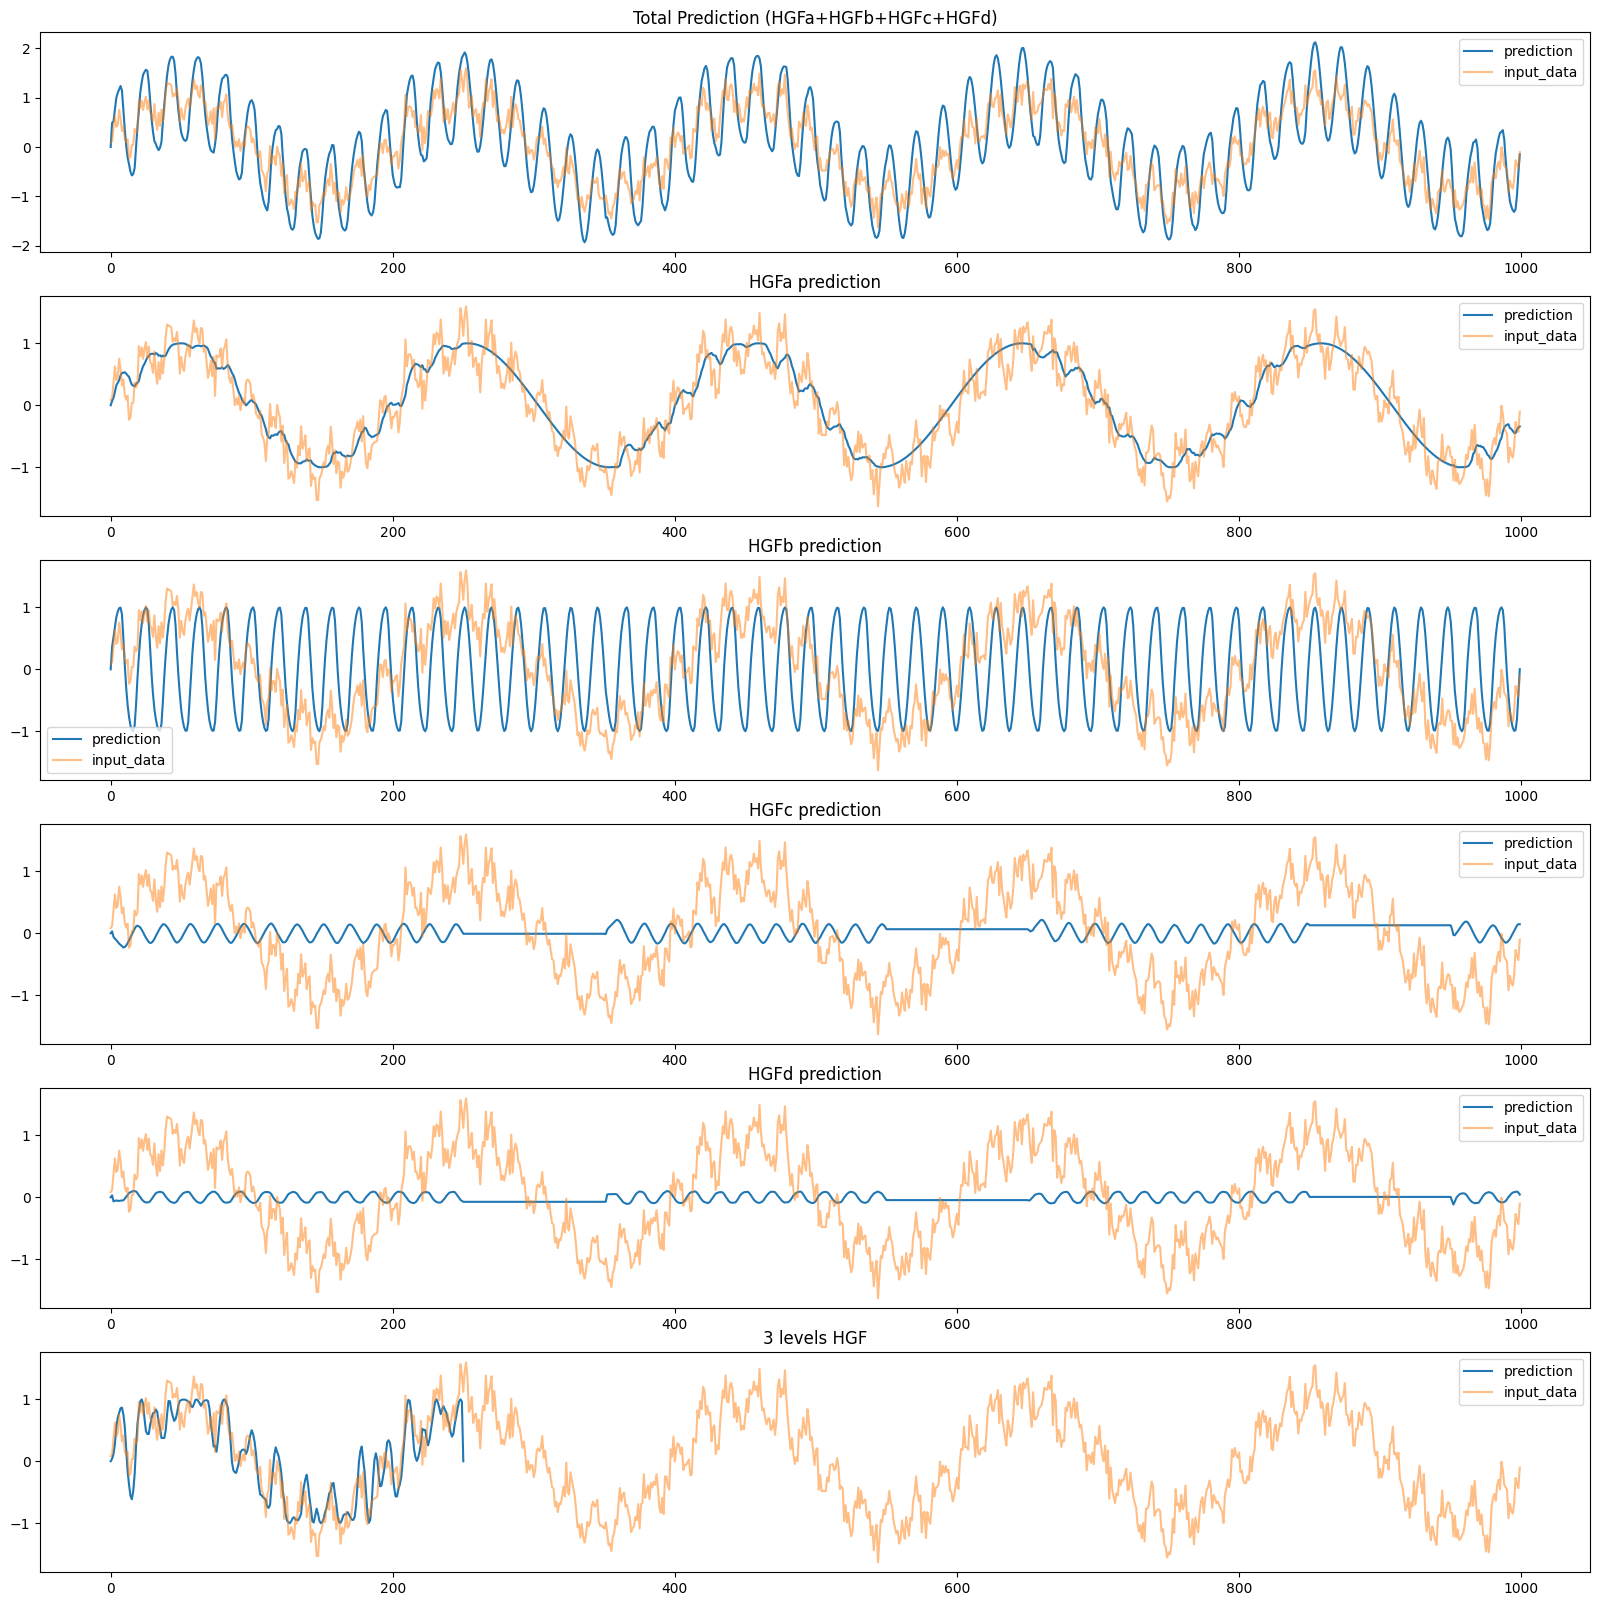

In [19]:
hgfa_prediction = hgfa.node_trajectories[1]["expected_mean"]
hgfb_prediction = hgfb.node_trajectories[1]["expected_mean"]
hgfc_prediction = hgfc.node_trajectories[1]["expected_mean"]
hgfd_prediction = hgfd.node_trajectories[1]["expected_mean"]
pehgf_total_prediction = hgfa_prediction + hgfb_prediction + hgfc_prediction + hgfd_prediction

fig, ax = plt.subplots(6,1, figsize=(20,20))

ax[0].plot(pehgf_total_prediction, label="prediction")
ax[0].plot(input_data, alpha=0.5, label="input_data")
ax[0].legend()
ax[0].set_title("Total Prediction (HGFa+HGFb+HGFc+HGFd)")

ax[1].plot(hgfa_prediction, label="prediction")
ax[1].plot(input_data, alpha=0.5, label="input_data")
ax[1].legend()
ax[1].set_title("HGFa prediction")

ax[2].plot(hgfb_prediction, label="prediction")
ax[2].plot(input_data, alpha=0.5, label="input_data")
ax[2].legend()
ax[2].set_title("HGFb prediction")

ax[3].plot(hgfc_prediction, label="prediction")
ax[3].plot(input_data, alpha=0.5, label="input_data")
ax[3].legend()
ax[3].set_title("HGFc prediction")

ax[4].plot(hgfd_prediction, label="prediction")
ax[4].plot(input_data, alpha=0.5, label="input_data")
ax[4].legend()
ax[4].set_title("HGFd prediction")

ax[5].plot(big_HGF.node_trajectories[1]["expected_mean"], label="prediction")
ax[5].plot(input_data, alpha=0.5, label="input_data")
ax[5].legend()
ax[5].set_title("3 levels HGF")




It is possible to notice that the fundemantal frequency content is in this way predicted correctly.
Notice that this kind of forecasting is not possible if a coupling function is not provided, as the first HGF is just setting its prediction error to 0, and, basing on the autoconnection strength, the predicted mean will remain stable or keep drifting with a constant slope.

Still, our concatenated HGFs have a tendency to overshoot - it is possible to reduce this problems by parametrizing the weight of each component (each singular hgf prediction mean) in the total sum.

Text(0.5, 1.0, 'Total Prediction (HGFa+HGFb+HGFc+HGFd)')

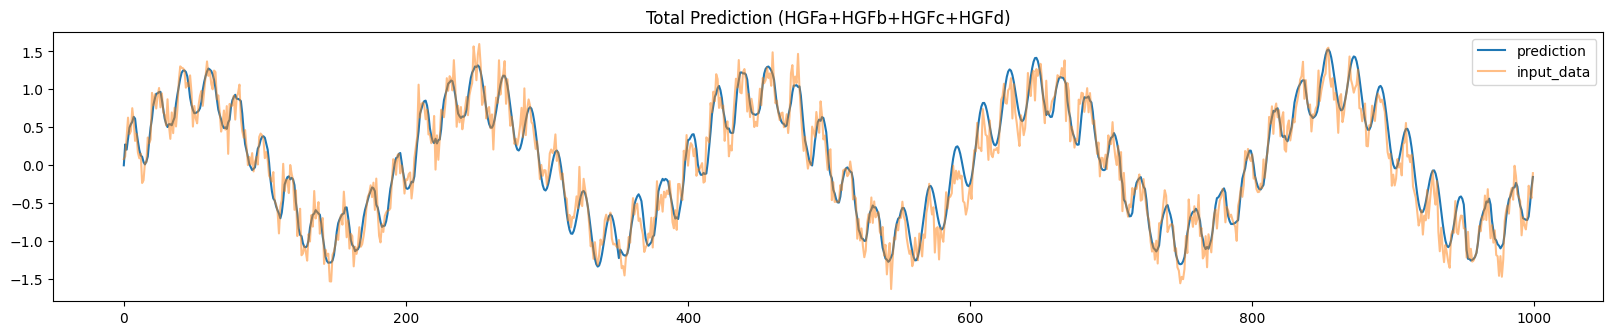

In [20]:
weights = (1,0.4,1,1)
pehgf_total_prediction = weights[0]*hgfa_prediction + weights[1]*hgfb_prediction + weights[2]*hgfc_prediction + weights[3]*hgfd_prediction

fig, ax = plt.subplots(1,1, figsize=(20,3.5))

ax.plot(pehgf_total_prediction, label="prediction")
ax.plot(input_data, alpha=0.5, label="input_data")
ax.legend()
ax.set_title("Total Prediction (HGFa+HGFb+HGFc+HGFd)")


Note that when the coupling function is not specified the concatenated-HGF will continue drifting. However, when new information is introduced, it will restart tracking the predicted mean quite accurately.

Even if in this case the forecasting is not optimal, such an implementation may help in dealing with cases, like this one, in which a singular HGF stops tracking the signal at all when some observations are missing.

In [21]:
hgfa = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=10.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,
               #coupling_fn=(jnp.sin,),
               #tonic_drift=omega_2,
               ) # x2 - node 2, clock parent


)

hgfb = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=10.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,
               #coupling_fn = (jnp.sin,),
               #tonic_drift = omega_1,
               ) # x2 - node 2, clock parent


)

hgfc = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=10.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,)
)


hgfd = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=100.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,) # x2 - node 2, value parent
)


big_HGF = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=100.0) # input 
    .add_nodes(value_children=0, 
               n_nodes=1, 
               autoconnection_strength=0) # x1 - node 1 
    .add_nodes(value_children=1, 
               n_nodes=1,
               autoconnection_strength=1,
               #coupling_fn =(jnp.sin,)
               ) # x2 - node 2, clock parent
    .add_nodes(value_children=2, 
               n_nodes=1,
               autoconnection_strength=1,
               tonic_volatility=-3) # x3 - node 3, value parent
)


(hgfa,hgfb,hgfc,hgfd) = concatenate_HGFs(HGFs =(hgfa,hgfb,hgfc,hgfd), 
                                         input_data = input_data,
                                         observed=observed,
                                         #input_type=("residual", "residual", "residual", "residual")
)

big_HGF = big_HGF.input_data(input_data, observed)

Text(0.5, 1.0, '3 levels HGF')

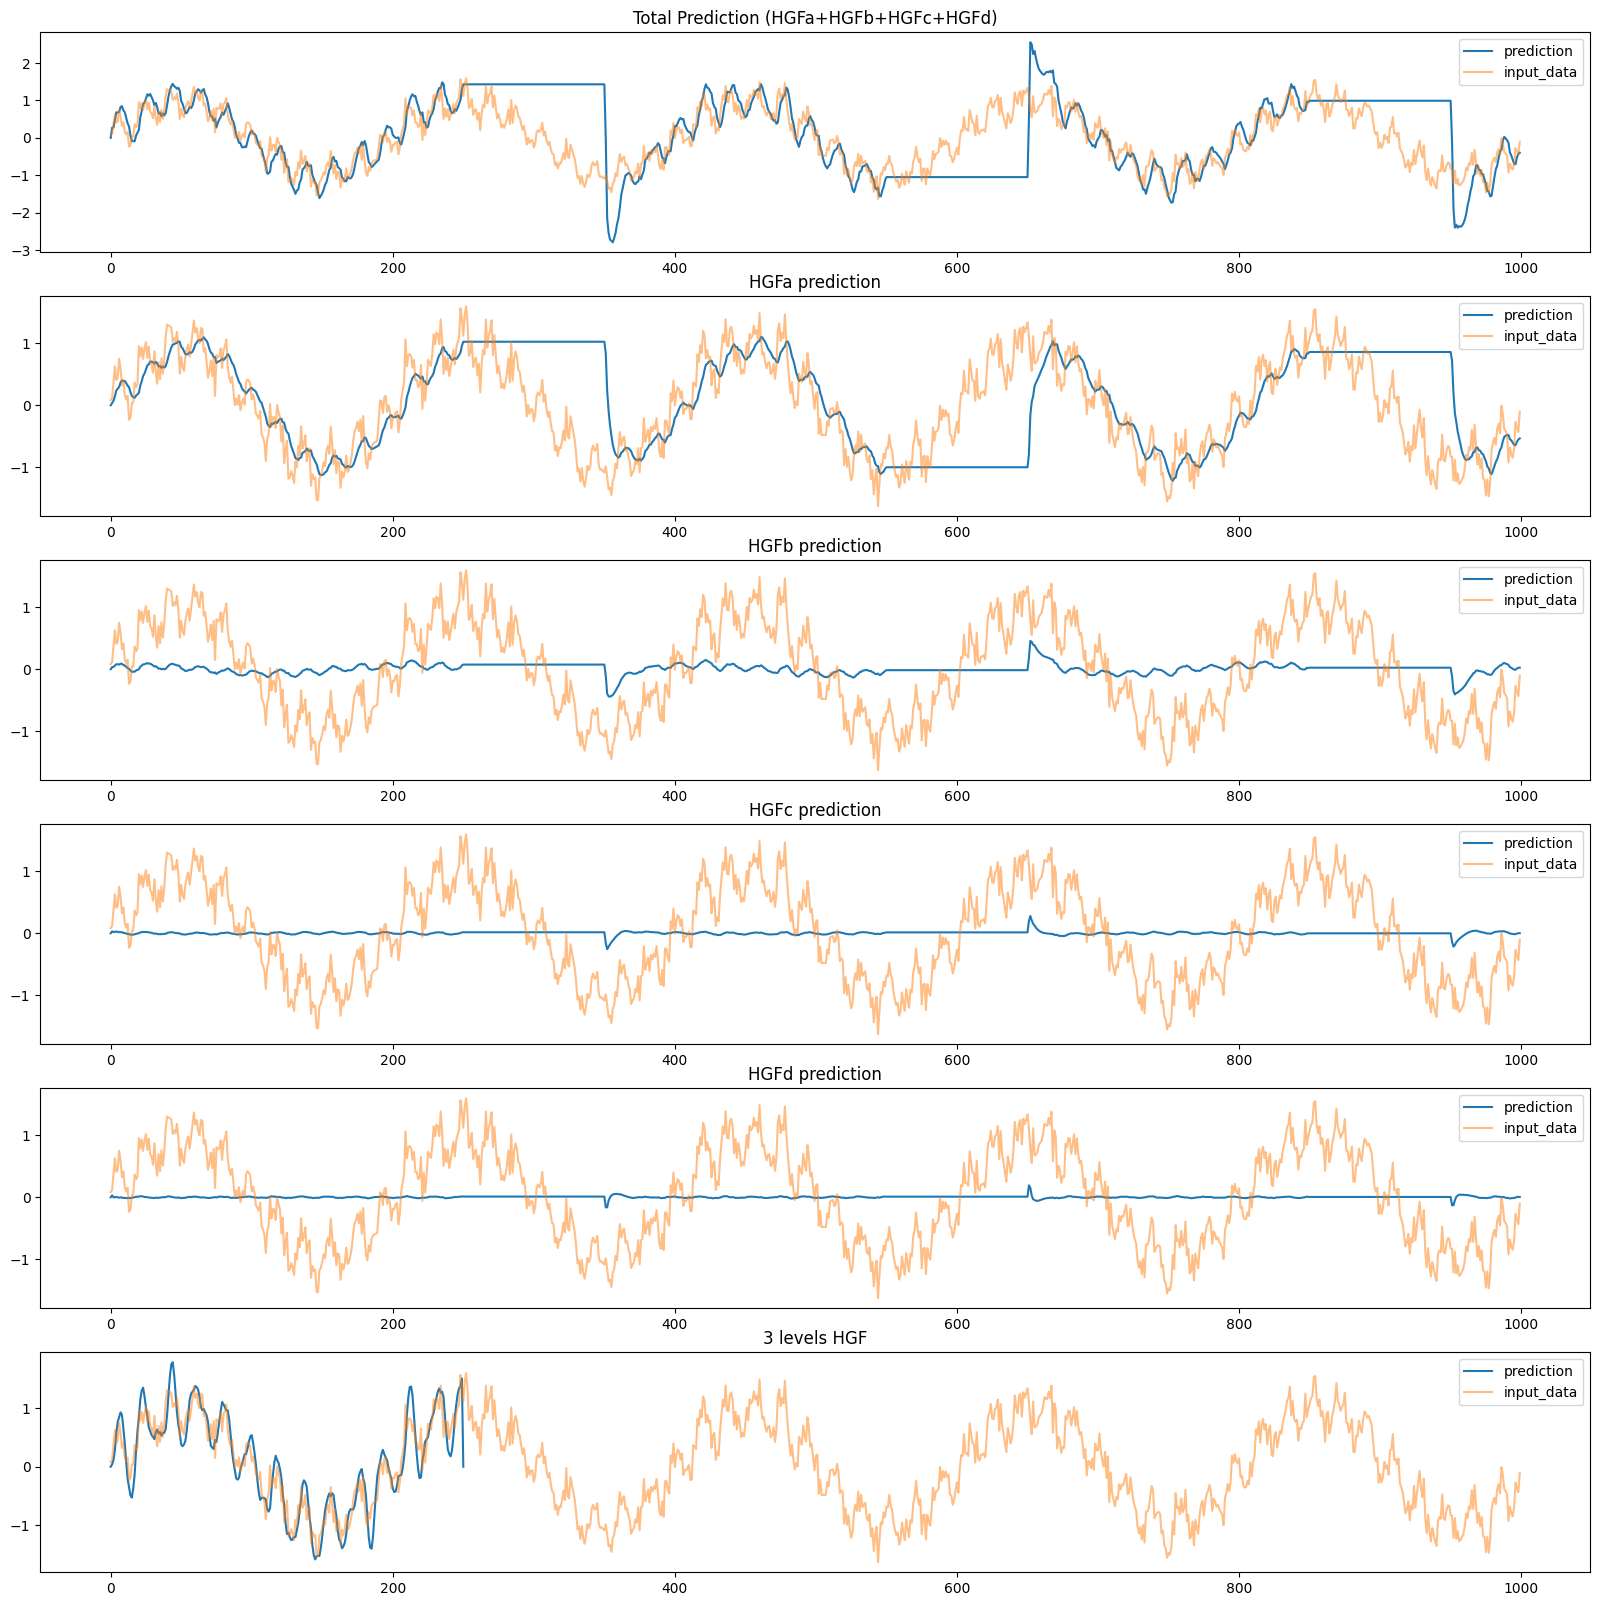

In [22]:
hgfa_prediction = hgfa.node_trajectories[1]["expected_mean"]
hgfb_prediction = hgfb.node_trajectories[1]["expected_mean"]
hgfc_prediction = hgfc.node_trajectories[1]["expected_mean"]
hgfd_prediction = hgfd.node_trajectories[1]["expected_mean"]
weights = (1,5,1,1)
pehgf_total_prediction = weights[0]*hgfa_prediction + weights[1]*hgfb_prediction + weights[2]*hgfc_prediction + weights[3]*hgfd_prediction

fig, ax = plt.subplots(6,1, figsize=(20,20))

ax[0].plot(pehgf_total_prediction, label="prediction")
ax[0].plot(input_data, alpha=0.5, label="input_data")
ax[0].legend()
ax[0].set_title("Total Prediction (HGFa+HGFb+HGFc+HGFd)")

ax[1].plot(hgfa_prediction, label="prediction")
ax[1].plot(input_data, alpha=0.5, label="input_data")
ax[1].legend()
ax[1].set_title("HGFa prediction")

ax[2].plot(hgfb_prediction, label="prediction")
ax[2].plot(input_data, alpha=0.5, label="input_data")
ax[2].legend()
ax[2].set_title("HGFb prediction")

ax[3].plot(hgfc_prediction, label="prediction")
ax[3].plot(input_data, alpha=0.5, label="input_data")
ax[3].legend()
ax[3].set_title("HGFc prediction")

ax[4].plot(hgfd_prediction, label="prediction")
ax[4].plot(input_data, alpha=0.5, label="input_data")
ax[4].legend()
ax[4].set_title("HGFd prediction")

ax[5].plot(big_HGF.node_trajectories[1]["expected_mean"], label="prediction")
ax[5].plot(input_data, alpha=0.5, label="input_data")
ax[5].legend()
ax[5].set_title("3 levels HGF")

# System configuration

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Fri Aug 23 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

pyhgf : 0.1.4
jax   : 0.4.28
jaxlib: 0.4.28

numpy     : 1.26.4
seaborn   : 0.13.2
pandas    : 2.2.2
matplotlib: 3.9.0
jax       : 0.4.28

Watermark: 2.4.3

